
# Generator of pairs of overlapping chromosomes:

As a cytogeneticist studying some features of the chromosomes (their telomeres, structural anomalies ...), you need to take pictures from chromosomal preparations fixed on glass slides . Unfortunately, like the sticks in the mikado game, sometime a chromosome or more can fall on an other one yielding overlapping chromosomes in the image, the plague of cytogeneticists. 

Computer based methods relying on geometric approaches, were developped to try to overcome this problem (Lunsteen & Piper, Minaee et al.). It seems possible that supervised methods based (NN) could learn to recognize overlapping domains of overlapping chromosomes. It is assumed that semantic segmentation based on artificial neural network could perform such recognition.

A large dataset of examples is supposed to be required to train a NN, so instead of screaning metaphases for overlapping chromosomes, it is bet that such overlapping can be artificially generated by systematically combining single chromosomes, possibly as follow:

  * Take a pair of metaphase images (dapi + Cy3(telomeres))
  * Zoom out the images (smaller images imply larger dataset until the RAM issue is fixed)
  * Substract background
  * Combine in one grey scale image
  * Segment and extract the single chromosomes:
      * make two subsets of chromosomes: one for training,one for validating
  * From a subset,make pairs of chromosomes.
  * for each pair of chromosomes:
      * generate all possible relative orientations by rotations
      * add a mask to each chromosome (mask=1 or 2, background=0)
          * for each orientation:
              * move one chromosome relatively to the other one.
              * mean the two grey-scaled images, sum the masks of each chromosomes so that pixels=3 belong to overlapping chromosomes domain.
              
### Size of the images: patching or not?
The size of the images of chromosomes is variable, there are small and large chromosomes. Furthermore since rotations are used, for a given chromosome, images of variable size ar generated. Thus a large set of variable sized images is generated.

To train a NN for semantic segmentation, it is assumed that the size of the images must be the same. To achieve this result, something like a patch can be applied to all the images. How to proceed?

  * generate all the images and store some kind of data in RAM then apply the patches:
       * there's an issue :the amount of RAM. To generate more examples, a solution can be to reduce the size of the images.
       * another possibility would be to store the images on disk, then resizing by batch in RAM. **How to store?**
           * in a single hdf5 file
           * just the pairs of images (greyscale+grountruth label) in png format.
       

On the other side, there's possibly solutions to handle data sets with varible size: such pytorch or tensorflow_fold, chainer.
       
              


## Import some libs

In [1]:
import sys
import itertools
import numpy as np # linear algebra
from scipy import ndimage as nd
import skimage as sk
from skimage import segmentation as skg
from skimage.measure import label
from skimage import io
import cv2
from matplotlib import pyplot as plt

In [2]:
import GenTool_02 as gt
#from Gentool_02 import extractParticles_2, clip_img_to_bounding_box

In [3]:
import h5py
import string

In [29]:
import warnings
import os

In [4]:
from subprocess import check_output
#print(check_output(["ls"]))
print check_output(["ls", "../dataset"]).decode("utf8")

82146_images
batch
Cy3.tif
DAPI.tif
LowRes
LowRes_13434_overlapping_pairs.h5
lowres_82146_overlapping_pairs_grey_DAPI-GroundTruth.h5
overlapping_chromosomes_examples.h5



## Load a metaphase

In [5]:
%matplotlib inline

In [6]:
cy3_12 = nd.imread('../dataset/Cy3.tif')[50:900,300:1150]
dapi_12 = nd.imread('../dataset/DAPI.tif')[50:900,300:1150]

zoom = 0.35
#dapi_small = nd.interpolation.zoom(dapi_12, 0.5, order=5, prefilter = True)

da_lr = nd.interpolation.zoom(dapi_12, zoom, order=5, prefilter = True)#dapi_12[::2, ::2]
c3_lr = nd.interpolation.zoom(cy3_12, zoom, order=5, prefilter = True)#cy3_12[::2, ::2]
#print dapi_12.shape, da_lr.shape, dapi_small.shape

/home/jeanpat/VirtualEnv/Venv2-SOS/local/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


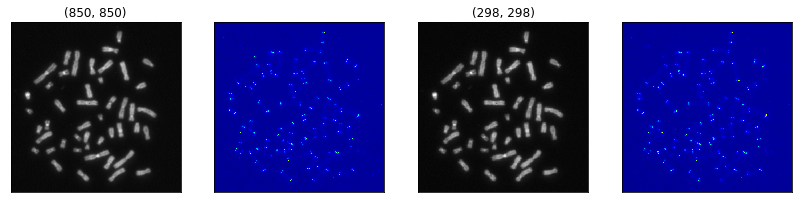

In [7]:
plt.figure(figsize=(14, 14))
plt.subplot(141, xticks=[], yticks=[])
plt.title(str(dapi_12.shape))
plt.imshow(dapi_12,  interpolation = 'nearest', cmap=plt.cm.gray)
plt.subplot(142,xticks=[], yticks=[])
plt.imshow(cy3_12, interpolation = 'nearest', cmap=plt.cm.jet)
plt.subplot(143,xticks=[], yticks=[])
plt.title(str(da_lr.shape))
plt.imshow(da_lr, interpolation = 'nearest', cmap=plt.cm.gray)
plt.subplot(144,xticks=[], yticks=[])
plt.imshow(c3_lr, interpolation = 'nearest', cmap=plt.cm.jet)

### Let's define structuring elements for further image segmentation

In [8]:
kernel100 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(35,35))
kernel18 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9))

## Let's convert the 12 bits images into 8 bits:

 - easier to handle for segmentation.
 - needed to make a rgb image.

In [9]:
d8 = np.uint8(da_lr/16.0)
cy8 = np.uint8(c3_lr/16.0)

### Let's make images with background set to zero

In [10]:
dapi_cv = cv2.morphologyEx(d8, cv2.MORPH_TOPHAT, kernel100)
cy3_cv = cv2.morphologyEx(cy8, cv2.MORPH_TOPHAT, kernel18)

dapi_cv = 1.0*dapi_cv - 5
dapi_cv[dapi_cv <0] = 0
dapi_cv = np.uint8(dapi_cv)

cy3_cv = 1.0*cy3_cv - 5
cy3_cv[cy3_cv<0] = 0
cy3_cv = np.uint8(cy3_cv)

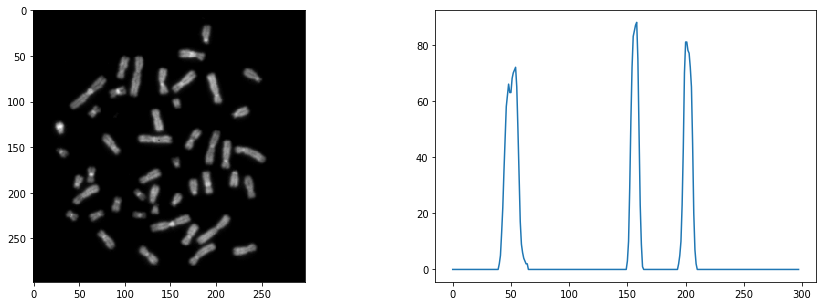

In [11]:
plt.figure(figsize=(15,5))
#plt.subplot(131, xticks=[], yticks=[])
#plt.imshow(color)
plt.subplot(121)#, xticks=[], yticks=[])
plt.imshow(dapi_cv, cmap=plt.cm.gray)
plt.subplot(122)#, xticks=[], yticks=[])
plt.plot(dapi_cv[100,:])

## Segment chromosomes:
 * segment chromosomes
 * combine dapi and cy3 components into one 8bits greyscaleimage
 * extract the single chromosomes

In [12]:
seg = sk.filters.threshold_adaptive(dapi_cv, block_size = 71)
seg = sk.morphology.binary_opening(seg, selem = sk.morphology.disk(3))
sk.segmentation.clear_border(seg, buffer_size=3, in_place= True)
labelled = label(seg)

In [13]:
dapi_cy3 = (1.0*dapi_cv + 1.0*cy3_cv)/2
combined = np.uint8(255*sk.exposure.rescale_intensity(dapi_cy3))

In [14]:
sd_greyscale = nd.standard_deviation(combined, labels=seg)
mean_greyscale = nd.mean(combined, labels = seg)

print "whole chromosomes mean intensity ans sd:", mean_greyscale, sd_greyscale

whole chromosomes mean intensity ans sd: 60.4248286224 26.702754535


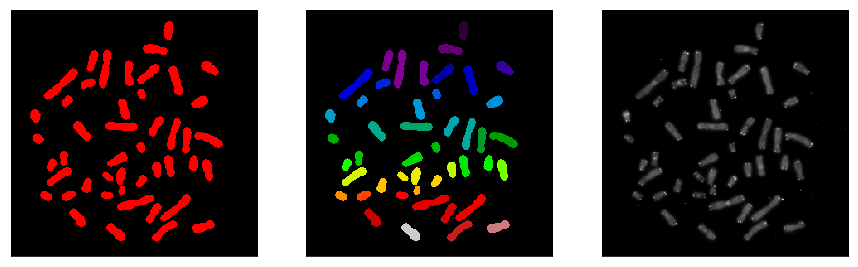

In [15]:
plt.figure(figsize=(15,5))
plt.subplot(131, xticks=[], yticks=[])
plt.imshow(seg,interpolation='nearest', cmap=plt.cm.flag_r)
plt.subplot(132, xticks=[], yticks=[])
plt.imshow(labelled,interpolation='nearest', cmap= plt.cm.spectral)
plt.subplot(133, xticks=[], yticks=[])
plt.imshow(combined,interpolation='nearest',cmap=plt.cm.gray)

In [16]:
single_chroms = gt.extractParticles_2(combined, labelled)

In [17]:
print len(single_chroms)

46


### Prepare two subsets of chromosomes:
   * sort chromosomes by size
   * select two subset of single chromosomes: one for training, the otherone for validation

In [18]:
singles = {}
for chrom in single_chroms:
    size = np.sum(chrom > 0)
    singles[size] = chrom
keys = singles.keys()
sorted_size = sorted(keys)
#half_karyotype = []
patched = gt.ResizeImages([singles[s] for s in sorted_size])

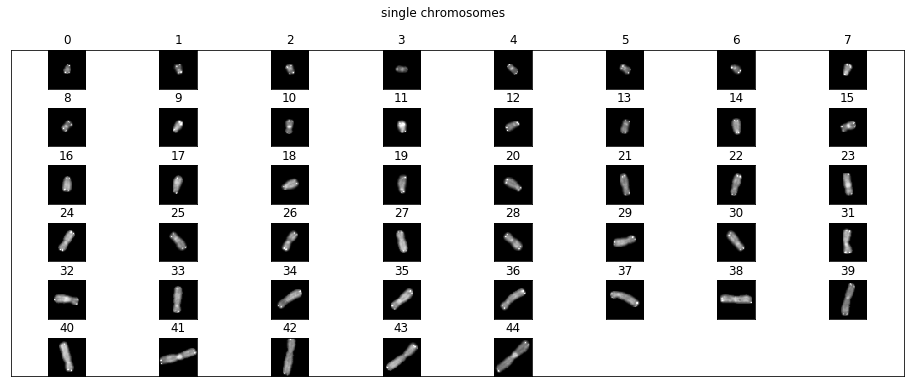

In [19]:
fig, ax = plt.subplots(figsize=(16, 6), subplot_kw={'xticks': [], 'yticks': []})
fig.subplots_adjust(hspace=.5)
fig.subplots_adjust(wspace= 0)
fig.suptitle("single chromosomes")
#fig.subplots_adjust(hspace=3, wspace=5)
for i, pat in enumerate(patched):#in range(46):#
    fig.add_subplot(6,8,i+1, xticks= [], yticks= [])
    plt.title(str(i))
    plt.imshow(pat, interpolation='nearest', cmap = plt.cm.Greys_r, vmin=0,vmax=150, )
    #plt.title(str(siz))

### Select two subsets of chromosomes:
   * one subset for training
   * one subset for validation

In [20]:
singles_train = [singles[sorted_size[i]] for i in [0, 3, 19, 27, 32, 36, 41]]#; print len(singles_train)
singles_valid = [singles[sorted_size[i]] for i in [1, 4,  8, 18, 28, 31, 42]]

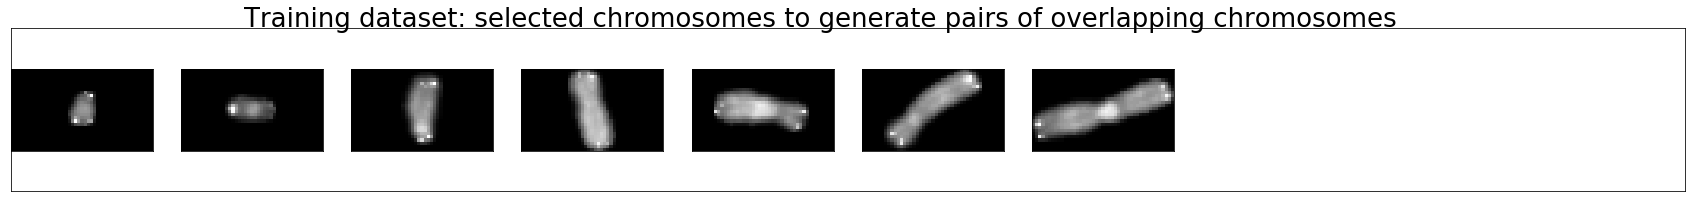

In [21]:
fig2, ax2 = plt.subplots(figsize=(30, 3), subplot_kw={'xticks': [], 'yticks': []})
fig2.suptitle("Training dataset: selected chromosomes to generate pairs of overlapping chromosomes", fontsize=26)
#fig.subplots_adjust(hspace=3, wspace=5)
for i, im in enumerate(gt.ResizeImages(singles_train)):#in range(46):#
    fig2.add_subplot(1,10,i+1, xticks= [], yticks= [])
    plt.imshow(im, interpolation='nearest', cmap = plt.cm.Greys_r, vmin=0,vmax=150, )

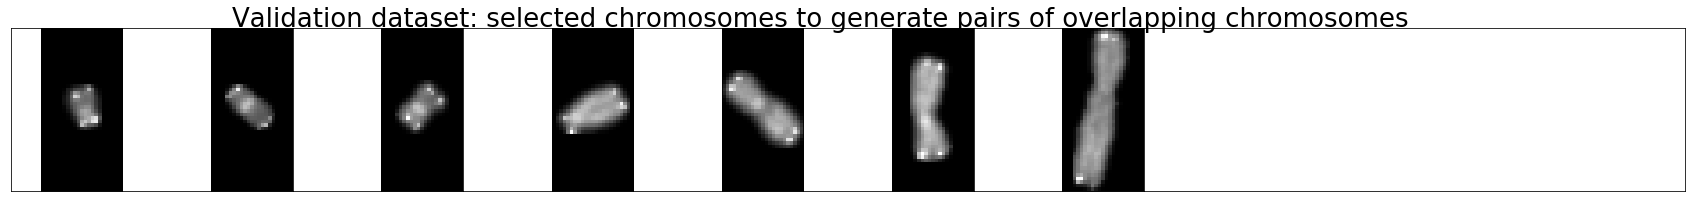

In [22]:
fig3, ax3 = plt.subplots(figsize=(30, 3), subplot_kw={'xticks': [], 'yticks': []})
fig3.suptitle("Validation dataset: selected chromosomes to generate pairs of overlapping chromosomes", fontsize=26)
#fig.subplots_adjust(hspace=3, wspace=5)
for i, im in enumerate(gt.ResizeImages(singles_valid)):#in range(46):#
    fig3.add_subplot(1,10,i+1, xticks= [], yticks= [])
    plt.imshow(im, interpolation='nearest', cmap = plt.cm.Greys_r, vmin=0,vmax=150, )

In [ ]:
print 7*6/(2)
print 21*((360/20)**2)*5**2

## The cell bellow will write the dataset to the disk

#### Generate the training dataset

In [24]:
# Use an iterator instead of a list:make pairs of chromosomes from the two subsets of single chromosomes
trainPairs_it = itertools.combinations(singles_train, 2)
validPairs_it = itertools.combinations(singles_valid, 2)

In [27]:
# loop in pairs of chromosomes
angleStep = 20
angles = [theta for theta in range(0,360, angleStep)]
half_turn = False
mask1 = 1
mask2 = 2
threshold = 0

pix_border = 6 #border of pixels to remove, to get some chr intersections
number_of_translations = 4
touch_label = 3

#for i in range(0, 40):next(trainPairs_it)#  for fast testing

ImageCount = 0
for i, pair in enumerate(trainPairs_it): ##MODIFY HERE TO CHANGE THE DATASET validPairs_it):#
    # prepare the rotations
    im1 = pair[0]
    im2 = pair[1]
    rotated1 = [nd.rotate(im1, angle) for angle in angles]# set of rotated chromosomes from one chrom
    rotated2 = [nd.rotate(im2, angle) for angle in angles]# set of rotated chromosomes from the other chrom
    rotated_couples = itertools.product(rotated1, rotated2)
    #print len(rotated1), ' ', len(rotated2)
    for j, orientation in enumerate(rotated_couples):
        ori1 = orientation[0]
        ori2 = orientation[1]
        masked1 = gt.clip_img_to_bounding_box(gt.add_mask_to_image(ori1, threshold, mask_value = mask1))
        masked2 = gt.clip_img_to_bounding_box(gt.add_mask_to_image(ori2, threshold, mask_value = mask2))
        #
        #Take the two masked images masked1,2 and generate translations:
        #
        #'''input :two images with a mask
        #output: list of images where thr moving img is translated
        #Horizontally and vertically relatively to the still img.
                
        row1, col1, _ = masked1.shape
        row2, col2, _ = masked2.shape
        border = pix_border 
        row = 2*row1 + row2 - border
        col = 2*col1 + col2 - border

        target1 = np.zeros((row, col,2), dtype = int)#+1
        target2 = np.zeros((row, col,2), dtype = int)#+1

        target1[0:row1, 0:col1, :] = masked1#moving_img
        target2[row1 - border/2:row1 + row2 - border/2, 
                col1 - border/2:col1 + col2 - border/2, :] = masked2#static_img

        #generate the translation vectors components: first horizontally, then vertically.
        max_row_trans = row1 + row2 - border
        max_col_trans = col1 + col2 - border
        #generate intermediate translations vectors
        row_T = [int((1.0*t/number_of_translations)*max_row_trans) for t in range(0, number_of_translations + 1)]
        col_T = [int((1.0*t/number_of_translations)*max_col_trans) for t in range(0, number_of_translations + 1)]
        U = [t for t in itertools.product(row_T,col_T)]
        for k, translation in enumerate(U):
            two_overlapping_chromosomes = gt.clip_img_to_bounding_box(target2 + gt.translate(target1, translation))
            ##just put image with overlapp
            if np.any(two_overlapping_chromosomes[:,:,1][:,:] == touch_label):
                ImageCount = ImageCount + 1
                                             
                ## MODIFY THE path where to save the dataset
                ## quit uggly comment/uncomment
                path_dataset_grey = '../dataset/LowRes/train/grey/'
                path_dataset_groundTruth = '../dataset/LowRes/train/groundtruth/'
                
                #path_dataset_grey = '../dataset/LowRes/validation/grey/'
                #path_dataset_groundTruth = '../dataset/LowRes/validation/groundtruth/'
                
                fileGrey = path_dataset_grey + "grey" + format(ImageCount,'07d') + '.png'
                fileGroundTruth = path_dataset_groundTruth + "gtruth" + format(ImageCount,'07d') + '.png'
                
                if ImageCount%10000 == 0: 
                    print 'saving:',fileGrey
                    print 'groundtruth:', fileGroundTruth
                    print "saved:", ImageCount
                
                ## issue with low contrast image : https://groups.google.com/forum/#!topic/scikit-image/lIqylsKVV4k
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    sk.io.imsave(fileGrey, two_overlapping_chromosomes[:,:,0])
                    sk.io.imsave(fileGroundTruth, two_overlapping_chromosomes[:,:,1])

saving: ../dataset/LowRes/train/grey/grey0010000.png
groundtruth: ../dataset/LowRes/train/groundtruth/gtruth0010000.png
saved: 10000
saving: ../dataset/LowRes/train/grey/grey0020000.png
groundtruth: ../dataset/LowRes/train/groundtruth/gtruth0020000.png
saved: 20000
saving: ../dataset/LowRes/train/grey/grey0030000.png
groundtruth: ../dataset/LowRes/train/groundtruth/gtruth0030000.png
saved: 30000
saving: ../dataset/LowRes/train/grey/grey0040000.png
groundtruth: ../dataset/LowRes/train/groundtruth/gtruth0040000.png
saved: 40000
saving: ../dataset/LowRes/train/grey/grey0050000.png
groundtruth: ../dataset/LowRes/train/groundtruth/gtruth0050000.png
saved: 50000
saving: ../dataset/LowRes/train/grey/grey0060000.png
groundtruth: ../dataset/LowRes/train/groundtruth/gtruth0060000.png
saved: 60000
saving: ../dataset/LowRes/train/grey/grey0070000.png
groundtruth: ../dataset/LowRes/train/groundtruth/gtruth0070000.png
saved: 70000
saving: ../dataset/LowRes/train/grey/grey0080000.png
groundtruth: ../

## Generate the validation dataset:
  * generate images of different size
  * then patch to get images of the same size 

In [42]:
# loop in pairs of chromosomes
angleStep = 20
angles = [theta for theta in range(0,360, angleStep)]
half_turn = False
mask1 = 1
mask2 = 2
threshold = 0

pix_border = 6 #border of pixels to remove, to get some chr intersections
number_of_translations = 4
touch_label = 3

#for i in range(0, 40):next(trainPairs_it)#  for fast testing

ImageCount = 0
for i, pair in enumerate(validPairs_it): ##MODIFY HERE TO CHANGE THE DATASET validPairs_it):#
    # prepare the rotations
    im1 = pair[0]
    im2 = pair[1]
    rotated1 = [nd.rotate(im1, angle) for angle in angles]# set of rotated chromosomes from one chrom
    rotated2 = [nd.rotate(im2, angle) for angle in angles]# set of rotated chromosomes from the other chrom
    rotated_couples = itertools.product(rotated1, rotated2)
    #print len(rotated1), ' ', len(rotated2)
    for j, orientation in enumerate(rotated_couples):
        ori1 = orientation[0]
        ori2 = orientation[1]
        masked1 = gt.clip_img_to_bounding_box(gt.add_mask_to_image(ori1, threshold, mask_value = mask1))
        masked2 = gt.clip_img_to_bounding_box(gt.add_mask_to_image(ori2, threshold, mask_value = mask2))
        #
        #Take the two masked images masked1,2 and generate translations:
        #
        #'''input :two images with a mask
        #output: list of images where thr moving img is translated
        #Horizontally and vertically relatively to the still img.
                
        row1, col1, _ = masked1.shape
        row2, col2, _ = masked2.shape
        border = pix_border 
        row = 2*row1 + row2 - border
        col = 2*col1 + col2 - border

        target1 = np.zeros((row, col,2), dtype = int)#+1
        target2 = np.zeros((row, col,2), dtype = int)#+1

        target1[0:row1, 0:col1, :] = masked1#moving_img
        target2[row1 - border/2:row1 + row2 - border/2, 
                col1 - border/2:col1 + col2 - border/2, :] = masked2#static_img

        #generate the translation vectors components: first horizontally, then vertically.
        max_row_trans = row1 + row2 - border
        max_col_trans = col1 + col2 - border
        #generate intermediate translations vectors
        row_T = [int((1.0*t/number_of_translations)*max_row_trans) for t in range(0, number_of_translations + 1)]
        col_T = [int((1.0*t/number_of_translations)*max_col_trans) for t in range(0, number_of_translations + 1)]
        U = [t for t in itertools.product(row_T,col_T)]
        for k, translation in enumerate(U):
            two_overlapping_chromosomes = gt.clip_img_to_bounding_box(target2 + gt.translate(target1, translation))
            ##just put image with overlapp
            if np.any(two_overlapping_chromosomes[:,:,1][:,:] == touch_label):
                ImageCount = ImageCount + 1
                                             
                ## MODIFY THE path where to save the dataset
                ## quit uggly comment/uncomment
                #path_dataset_grey = '../dataset/LowRes/train/grey/'
                #path_dataset_groundTruth = '../dataset/LowRes/train/groundtruth/'
                
                path_dataset_grey = '../dataset/LowRes/validation/grey/'
                path_dataset_groundTruth = '../dataset/LowRes/validation/groundtruth/'
                
                fileGrey = path_dataset_grey + "grey" + format(ImageCount,'07d') + '.png'
                fileGroundTruth = path_dataset_groundTruth + "gtruth" + format(ImageCount,'07d') + '.png'
                
                if ImageCount%10000 == 0: 
                    print 'saving:',fileGrey
                    print 'groundtruth:', fileGroundTruth
                    print "saved:", ImageCount
                
                ## issue with low contrast image : https://groups.google.com/forum/#!topic/scikit-image/lIqylsKVV4k
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    sk.io.imsave(fileGrey, two_overlapping_chromosomes[:,:,0])
                    sk.io.imsave(fileGroundTruth, two_overlapping_chromosomes[:,:,1])

saving: ../dataset/LowRes/validation/grey/grey0010000.png
groundtruth: ../dataset/LowRes/validation/groundtruth/gtruth0010000.png
saved: 10000
saving: ../dataset/LowRes/validation/grey/grey0020000.png
groundtruth: ../dataset/LowRes/validation/groundtruth/gtruth0020000.png
saved: 20000
saving: ../dataset/LowRes/validation/grey/grey0030000.png
groundtruth: ../dataset/LowRes/validation/groundtruth/gtruth0030000.png
saved: 30000
saving: ../dataset/LowRes/validation/grey/grey0040000.png
groundtruth: ../dataset/LowRes/validation/groundtruth/gtruth0040000.png
saved: 40000
saving: ../dataset/LowRes/validation/grey/grey0050000.png
groundtruth: ../dataset/LowRes/validation/groundtruth/gtruth0050000.png
saved: 50000
saving: ../dataset/LowRes/validation/grey/grey0060000.png
groundtruth: ../dataset/LowRes/validation/groundtruth/gtruth0060000.png
saved: 60000
saving: ../dataset/LowRes/validation/grey/grey0070000.png
groundtruth: ../dataset/LowRes/validation/groundtruth/gtruth0070000.png
saved: 70000

## Let's have a look at an images sample of train dataset:

In [30]:
samplesize = 36
total = len(os.listdir(os.path.join('..','dataset','LowRes','train','grey')))
someindexes = np.floor(total*np.random.random_sample(size = samplesize)).astype(int)

path_train_dataset_grey = os.path.join('..','dataset','LowRes','train','grey')
path_train_dataset_groundTruth = os.path.join('..','dataset','LowRes','train','groundtruth')

sample = []
for i, indx in enumerate(someindexes):
    ImIndex = format(indx, '07d')
    fileGrey        = path_train_dataset_grey        + '/grey'   + ImIndex + '.png'
    fileGroundTruth = path_train_dataset_groundTruth + '/gtruth' + ImIndex + '.png'

    grey = sk.io.imread(fileGrey)
    groundTruth = sk.io.imread(fileGroundTruth)
    
    sample.append((grey, groundTruth))

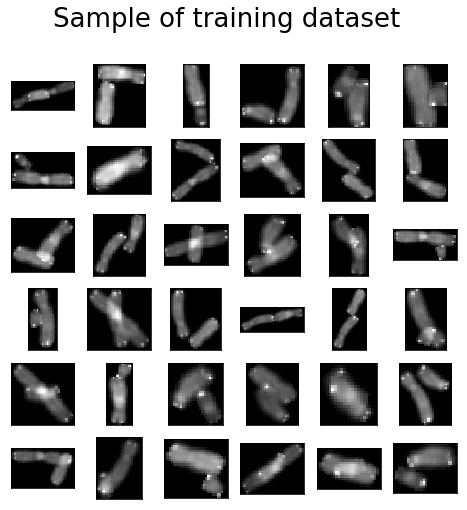

In [31]:
fig4, ax4= plt.subplots(figsize=(8, 8), subplot_kw={'xticks': [], 'yticks': []})
fig4.suptitle("Sample of training dataset", fontsize=26)

for i, pair in enumerate(sample):
    
    plt.subplot(6, 6,i+1,xticks=[],yticks=[])
    #plt.imshow(groundTruth, interpolation = 'nearest',cmap = plt.cm.Greys_r)
    #plt.subplot(122,xticks=[],yticks=[])
    grey = pair[0]
    plt.imshow(grey, interpolation = 'nearest', cmap= plt.cm.gray)

## As it can be seen, the size of the sample varies:

Let's patch the images so that all the images of the datasets (train + validation) have the same size.

#### First pass:
Let's record the dimensions of the largest image in the train or validation dataset. 

In [43]:
##Search size of the largest image in the train dataset

row_max = 0
col_max = 0

total = len(os.listdir(os.path.join('..','dataset','LowRes','train','grey')))
path_dataset_grey = os.path.join('..','dataset','LowRes','train','grey')


for indx in range(total):
    ImIndex = format(indx+1, '07d')
    fileGrey = path_dataset_grey + '/grey' + ImIndex + '.png'
   
    grey = sk.io.imread(fileGrey)
    
    row = grey.shape[0]
    col = grey.shape[1]
    if row > row_max:
        row_max = row
    if col > col_max:
        col_max = col
        
total = len(os.listdir(os.path.join('..','dataset','LowRes','validation','grey')))
path_dataset_grey = os.path.join('..','dataset','LowRes','validation','grey')


for indx in range(total):
    ImIndex = format(indx+1, '07d')
    fileGrey = path_dataset_grey + '/grey' + ImIndex + '.png'

    grey = sk.io.imread(fileGrey)
    
    row = grey.shape[0]
    col = grey.shape[1]
    if row > row_max:
        row_max = row
    if col > col_max:
        col_max = col
        
print 'largest dimensions (row,col):', row_max,col_max


largest dimensions (row,col): 80 82


### Now patch all the images in **train** dataset (grey, groundtruth) 
#### *second pass* : read, patch, save.

In [33]:

total = len(os.listdir(os.path.join('..','dataset','LowRes','train','grey')))
path_dataset_grey = os.path.join('..','dataset','LowRes','train','grey')
path_dataset_groundtruth = os.path.join('..','dataset','LowRes','train','groundtruth')

print "total image in train dataset:", total
print "    path to grey:", path_dataset_grey
print "    path to groundtruth:", path_dataset_groundtruth

count = 0
for indx in range(total):
    ImIndex = format(indx+1, '07d')
    fileGrey = os.path.join(path_dataset_grey, 'grey' + ImIndex + '.png')
    fileGroundtruth = os.path.join(path_dataset_groundtruth, 'gtruth' + ImIndex + '.png')

    grey = sk.io.imread(fileGrey)
    gtru = sk.io.imread(fileGroundtruth)
    
    #print 'read grey:',fileGrey
    #print 'read groundtruth:',fileGroundtruth
    # grey.shape == gtru.shape must be True
    width = grey.shape[1]
    height = gtru.shape[0]

    diffw = col_max-width
    diffh = row_max-height
    starth = int(round(diffh/2))
    startw = int(round(diffw/2))
    
    count = count + 1
    if count % 10000 == 0 : print 'image:', count
    
    for i, image in enumerate((grey, gtru)):
        
        newIm=np.zeros((row_max,col_max), dtype=np.uint8)
        newIm[starth:starth+height,startw:startw+width] = image
        
                   
        if i==0:# grey image
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                sk.io.imsave(fileGrey, newIm)
   
        if i==1:# groundtruth image
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                sk.io.imsave(fileGroundtruth, newIm)

total image in train dataset: 100085
    path to grey: ../dataset/LowRes/train/grey
    path to groundtruth: ../dataset/LowRes/train/groundtruth
image: 10000
image: 20000
image: 30000
image: 40000
image: 50000
image: 60000
image: 70000
image: 80000
image: 90000
image: 100000
image: 110000
image: 120000
image: 130000
image: 140000
image: 150000
image: 160000
image: 170000
image: 180000
image: 190000
image: 200000


## Have a look to the patched train dataset:

In [34]:
samplesize = 36
total = len(os.listdir(os.path.join('..','dataset','LowRes','train','grey')))
someindexes = np.floor(total*np.random.random_sample(size = samplesize)).astype(int)

path_train_dataset_grey = os.path.join('..','dataset','LowRes','train','grey')
path_train_dataset_groundTruth = os.path.join('..','dataset','LowRes','train','groundtruth')

sample = []
for i, indx in enumerate(someindexes):
    ImIndex = format(indx, '07d')
    fileGrey        = path_train_dataset_grey        + '/grey'   + ImIndex + '.png'
    fileGroundTruth = path_train_dataset_groundTruth + '/gtruth' + ImIndex + '.png'

    grey = sk.io.imread(fileGrey)
    groundTruth = sk.io.imread(fileGroundTruth)
    
    sample.append((grey, groundTruth))

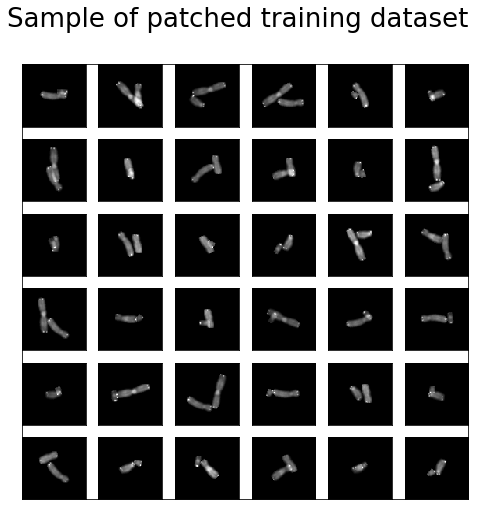

In [40]:
fig4, ax4= plt.subplots(figsize=(8, 8), subplot_kw={'xticks': [], 'yticks': []})
fig4.suptitle("Sample of patched training dataset", fontsize=26)

for i, pair in enumerate(sample):
    
    fig4.add_subplot(6, 6,i+1,xticks=[],yticks=[])
    #plt.imshow(groundTruth, interpolation = 'nearest',cmap = plt.cm.Greys_r)
    #plt.subplot(122,xticks=[],yticks=[])
    grey = pair[0]
    plt.imshow(grey, interpolation = 'nearest', cmap= plt.cm.gray)

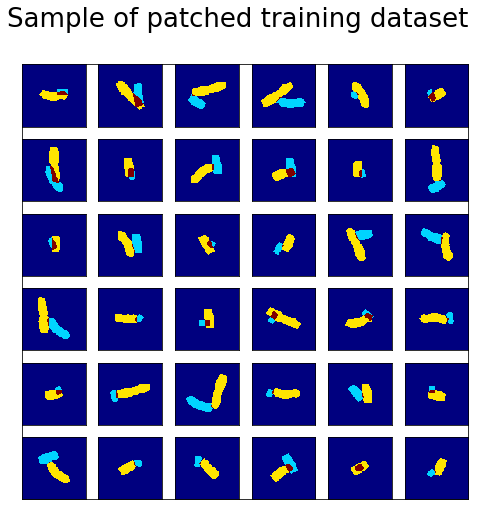

In [41]:
fig4, ax4= plt.subplots(figsize=(8, 8), subplot_kw={'xticks': [], 'yticks': []})
fig4.suptitle("Sample of patched training dataset", fontsize=26)

for i, pair in enumerate(sample):
    
    fig4.add_subplot(6, 6,i+1,xticks=[],yticks=[])
    #plt.imshow(groundTruth, interpolation = 'nearest',cmap = plt.cm.Greys_r)
    #plt.subplot(122,xticks=[],yticks=[])
    grey = pair[1]
    plt.imshow(grey, interpolation = 'nearest', cmap= plt.cm.jet)

## Have a look to the validation dataset

In [44]:
samplesize = 36
total = len(os.listdir(os.path.join('..','dataset','LowRes','validation','grey')))
someindexes = np.floor(total*np.random.random_sample(size = samplesize)).astype(int)

path_train_dataset_grey = os.path.join('..','dataset','LowRes','validation','grey')
path_train_dataset_groundTruth = os.path.join('..','dataset','LowRes','validation','groundtruth')

sample_validation = []
for i, indx in enumerate(someindexes):
    ImIndex = format(indx, '07d')
    fileGrey        = path_train_dataset_grey        + '/grey'   + ImIndex + '.png'
    fileGroundTruth = path_train_dataset_groundTruth + '/gtruth' + ImIndex + '.png'

    grey = sk.io.imread(fileGrey)
    groundTruth = sk.io.imread(fileGroundTruth)
    
    sample_validation.append((grey, groundTruth))

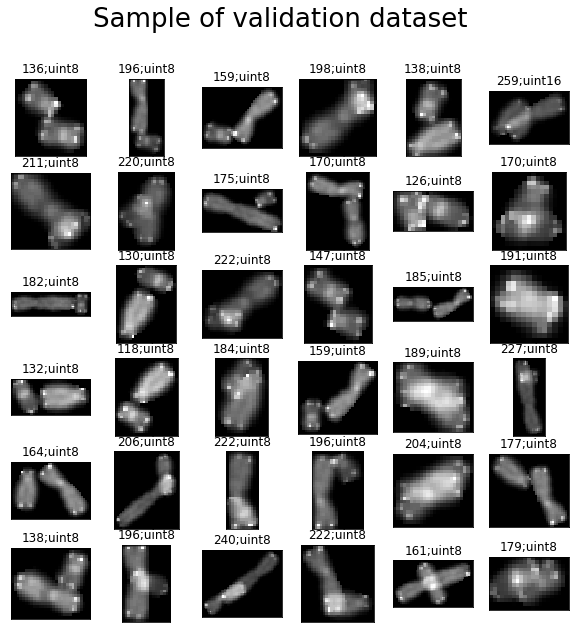

In [45]:
fig4, ax4= plt.subplots(figsize=(10, 10), subplot_kw={'xticks': [], 'yticks': []})
fig4.suptitle("Sample of validation dataset", fontsize=26)

for i, pair in enumerate(sample_validation):
    
    plt.subplot(6, 6,i+1,xticks=[],yticks=[])
    grey = pair[0]
    plt.title(str(grey.max()) + ';' + str(grey.dtype))
    plt.imshow(grey, interpolation = 'nearest', cmap= plt.cm.gray)

## Patch the validation dataset

In [46]:
total = len(os.listdir(os.path.join('..','dataset','LowRes','validation','grey')))
path_dataset_grey = os.path.join('..','dataset','LowRes','validation','grey')
path_dataset_groundtruth = os.path.join('..','dataset','LowRes','validation','groundtruth')

print "total image in validation dataset:", total
print "    path to grey:", path_dataset_grey
print "    path to groundtruth:", path_dataset_groundtruth

count = 0
for indx in range(total):
    ImIndex = format(indx+1, '07d')
    fileGrey = os.path.join(path_dataset_grey, 'grey' + ImIndex + '.png')
    fileGroundtruth = os.path.join(path_dataset_groundtruth, 'gtruth' + ImIndex + '.png')

    grey = sk.io.imread(fileGrey)
    gtru = sk.io.imread(fileGroundtruth)
    
    # grey.shape == gtru.shape must be True
    width = grey.shape[1]
    height = gtru.shape[0]

    diffw = col_max-width
    diffh = row_max-height
    starth = int(round(diffh/2))
    startw = int(round(diffw/2))
    
    count = count + 1
    if count % 1000 == 0 : print 'image:', count
    
    for i, image in enumerate((grey, gtru)):
        
        newIm=np.zeros((row_max,col_max), dtype=np.uint8)
        newIm[starth:starth+height,startw:startw+width] = image
        
                  
        if i==0:# grey image
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                sk.io.imsave(fileGrey, newIm)
         
        if i==1:# groundtruth image
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                sk.io.imsave(fileGroundtruth, newIm)

total image in validation dataset: 111223
    path to grey: ../dataset/LowRes/validation/grey
    path to groundtruth: ../dataset/LowRes/validation/groundtruth
image: 1000
image: 2000
image: 3000
image: 4000
image: 5000
image: 6000
image: 7000
image: 8000
image: 9000
image: 10000
image: 11000
image: 12000
image: 13000
image: 14000
image: 15000
image: 16000
image: 17000
image: 18000
image: 19000
image: 20000
image: 21000
image: 22000
image: 23000
image: 24000
image: 25000
image: 26000
image: 27000
image: 28000
image: 29000
image: 30000
image: 31000
image: 32000
image: 33000
image: 34000
image: 35000
image: 36000
image: 37000
image: 38000
image: 39000
image: 40000
image: 41000
image: 42000
image: 43000
image: 44000
image: 45000
image: 46000
image: 47000
image: 48000
image: 49000
image: 50000
image: 51000
image: 52000
image: 53000
image: 54000
image: 55000
image: 56000
image: 57000
image: 58000
image: 59000
image: 60000
image: 61000
image: 62000
image: 63000
image: 64000
image: 65000
imag

### Have a look to the validation dataset after patching

In [52]:
samplesize = 100
total = len(os.listdir(os.path.join('..','dataset','LowRes','validation','grey')))
someindexes = np.floor(total*np.random.random_sample(size = samplesize)).astype(int)

path_train_dataset_grey = os.path.join('..','dataset','LowRes','validation','grey')
path_train_dataset_groundTruth = os.path.join('..','dataset','LowRes','validation','groundtruth')

sample_validation = []
for i, indx in enumerate(someindexes):
    ImIndex = format(indx, '07d')
    fileGrey        = path_train_dataset_grey        + '/grey'   + ImIndex + '.png'
    fileGroundTruth = path_train_dataset_groundTruth + '/gtruth' + ImIndex + '.png'

    grey = sk.io.imread(fileGrey)
    groundTruth = sk.io.imread(fileGroundTruth)
    
    sample_validation.append((grey, groundTruth))

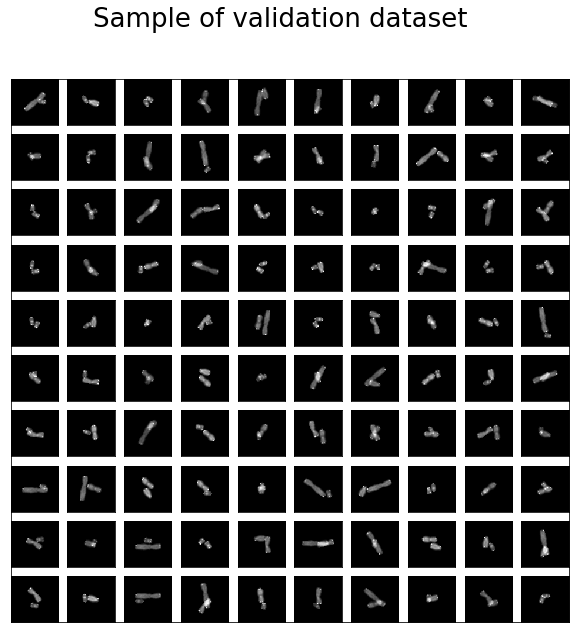

In [53]:
fig5, ax5 = plt.subplots(figsize=(10, 10), subplot_kw={'xticks': [], 'yticks': []})
fig5.suptitle("Sample of validation dataset", fontsize=26)

for i, pair in enumerate(sample_validation):
    
    fig5.add_subplot(10, 10,i+1,xticks=[],yticks=[])
    grey = pair[0]
    #plt.title(str(grey.max()) + ';' + str(grey.dtype))
    plt.imshow(grey, interpolation = 'nearest', cmap= plt.cm.gray)

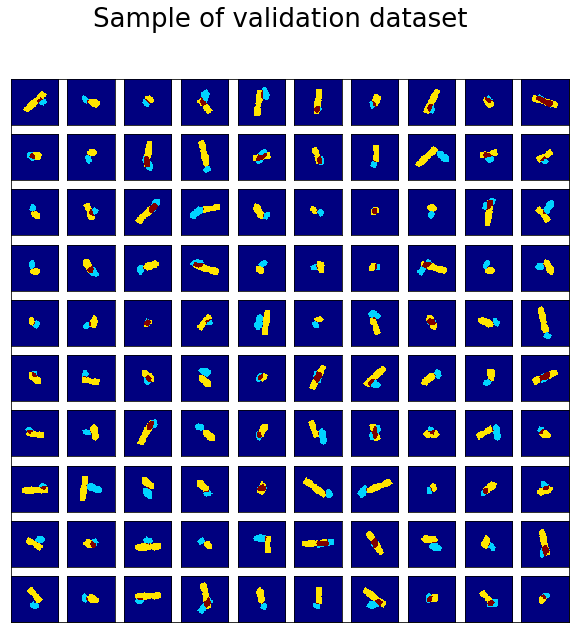

In [54]:
fig5, ax5 = plt.subplots(figsize=(10, 10), subplot_kw={'xticks': [], 'yticks': []})
fig5.suptitle("Sample of validation dataset", fontsize=26)

for i, pair in enumerate(sample_validation):
    
    fig5.add_subplot(10, 10,i+1,xticks=[],yticks=[])
    grey = pair[1]
    #plt.title(str(grey.max()) + ';' + str(grey.dtype))
    plt.imshow(grey, interpolation = 'nearest', cmap= plt.cm.jet)